In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle

In [3]:
from model import C2F_TCN
from dataset import AugmentDataset, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='4'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=50,
    learning_rate=1e-4,
    weight_decay=3e-3,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=10,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 50, 'learning_rate': 0.0001, 'weight_decay': 0.003, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 10, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split': '/mnt/

In [22]:
# traindataset = AugmentDataset(config, fold='train', fold_file_name=config.semi_supervised_split, augment=False)
traindataset = AugmentDataset(config, fold='train', fold_file_name=config.train_split_file, augment=False)
testdataset = AugmentDataset(config, fold='test', fold_file_name=config.test_split_file, augment=False)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=7, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [30]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [33]:
loaded_vidid_selected_frames = pickle.load(open("dump_dir/breakfast_split2_selected_frames_dict.pkl", "rb"))
# loaded_vidid_selected_frames

In [34]:
video_id_boundary_frames = pickle.load(open("dump_dir/breakfast_split2_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [12]:
set_seed()
model = C2F_TCN(n_channels=config.feature_size, n_classes=config.num_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-3)

# Requires loaded_vidid_selected_frames, boundaries_dict
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, cumsum_feat, cur_vid_count, window=2):
    prob_each_segment = []
    window = 5
    
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]

        distance = []
        for j in range(cur_ele, next_ele):
            leftmost = max(j - window, 0)
            rightmost = min(j + window, cur_vid_count - 1)
            avg_feature = torch.mean(cur_vid_feat[leftmost: rightmost+1], dim=0)
            dist = cos(avg_feature, cur_vid_feat[leftmost]) + cos(avg_feature, cur_vid_feat[rightmost])
#             dist = -torch.max(torch.abs(avg_feature - cur_vid_feat[leftmost]))
#             dist += -torch.max(torch.abs(avg_feature - cur_vid_feat[rightmost+1]))
            distance.append(dist)
            
        prob = torch.softmax(-torch.stack(distance)*10, dim=0)
        prob_each_segment.append(prob)

    return prob_each_segment

In [14]:
boundaries_dict = {}

In [15]:
def get_estimated_boundary(data_feat, data_count, video_ids, window=2): #, loaded_vidid_selected_frames, boundaries_dict):
    global boundaries_dict
    # Requires loaded_vidid_selected_frames, boundaries_dict
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
        prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, cumsum_feat, cur_vid_count)
        bound_list = []
        for i, cur_seg_prob in enumerate(prob_each_segment):
            sum_prob = torch.sum(cur_seg_prob)
            
            current_frame_index = torch.tensor(np.arange(selected_frames[i],
                                                         selected_frames[i + 1], 1), 
                                               dtype=torch.long, device=cur_vid_feat.device)
            sum_prob_ele = torch.sum(cur_seg_prob * current_frame_index)
            expected_bound = sum_prob_ele / sum_prob
        
            bound_list.append(int(expected_bound.item() + 1e-3))

        bound_list.append((cur_vid_count - 1).item())
        boundaries_dict[cur_vidid] = torch.tensor(bound_list, dtype=torch.long, device=cur_vid_feat.device)

In [16]:
def get_boundary_probabilities(data_feat, data_count, video_ids, p_boundary): #, loaded_vidid_selected_frames, boundaries_dict):
    prob_list = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid], dtype=torch.long, 
                                       device=cur_vid_feat.device)
        bound_list = p_boundary[cur_vidid].to(device)

        cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
        
        avg_from_st_ele = (cumsum_feat[bound_list[:-1], :] - cumsum_feat[(selected_frames[:-1] - 1), :]) / \
                            ((bound_list[:-1] - (selected_frames[:-1] - 1))[:, None])
            
        avg_from_end_ele = cumsum_feat[selected_frames[1:], :] - cumsum_feat[(bound_list[:-1] - 1), :] / \
                               ((selected_frames[1:] - (bound_list[:-1] - 1))[:, None])
        
        dist_value_1 = cos(cur_vid_feat[selected_frames[:-1], :], avg_from_st_ele)
        dist_value_2 = cos(cur_vid_feat[selected_frames[1:], :], avg_from_end_ele)
#         dist_value_1 = torch.norm(cur_vid_feat[selected_frames[:-1], :] - avg_from_st_ele, dim=1)
#         dist_value_2 = torch.norm(cur_vid_feat[selected_frames[1:], :] - avg_from_end_ele, dim=1)
        
        dist_value_1 = torch.exp(dist_value_1 / 0.1)
        dist_value_2 = torch.exp(dist_value_2 / 0.1)

        prob = dist_value_1 #/ (dist_value_1 + dist_value_2)
#         prob = dist_value_2 / (dist_value_1 + dist_value_2)
        if torch.any(torch.isnan(prob)):
            import pdb
            pdb.set_trace()
        
        sum_prob_list = []
        prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, cumsum_feat)
        for i, cur_seg_prob in enumerate(prob_each_segment):
            sum_prob = torch.sum(cur_seg_prob)
            sum_prob_list.append(sum_prob)

        final_prob = prob / torch.tensor(sum_prob_list, dtype=prob.dtype, device=prob.device)
        prob_list.append(final_prob)
        
    return torch.cat(prob_list)

In [17]:
def get_boundary_err():
    err_list = []
    for ele in boundaries_dict.keys():
        estimated = boundaries_dict[ele].detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
    print(f"Avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")

In [27]:
def get_classification_loss(features, labels_all, video_ids):
    global ce_criterion
    labels_arr = []
    selected_probs_arr = []
    for iter_num in range(len(features)):
        cur_vid_feat = features[iter_num].T
        cur_vidid = video_ids[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid], dtype=torch.long, 
                                       device=cur_vid_feat.device)
        selected_labels = labels[selected_frames]
        selected_probs = cur_vid_feat[selected_frames, :]
        
        labels_arr.append(selected_labels)
        selected_probs_arr.append(selected_probs)
        
    labels_arr = torch.cat(labels_arr)
    selected_probs_arr = torch.cat(selected_probs_arr)
    
    return ce_criterion(selected_probs_arr, labels_arr)

In [28]:
for i, item in enumerate(trainloader):
    with torch.no_grad():
        get_estimated_boundary(item[0], item[1], item[5])
get_boundary_err()

for epoch in range(500):
    print("Starting Maximization")
    for i, item in enumerate(trainloader):
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        
        optimizer.zero_grad()
        y, _, features = model(item[0].permute(0,2,1))
        loss_ce = get_classification_loss(y, item[2].to(device), item[5])

        features = features.permute(0, 2, 1)
        frame_proba = get_boundary_probabilities(features, item[1], item[5], boundaries_dict)
        loss_em = -torch.mean(torch.log(frame_proba + 1e-4))
        
        loss = loss_ce + loss_em
        loss.backward()
        optimizer.step()
        if i%10==0:
            print(f"Current loss {loss.item()}")
            
    if epoch % 10 == 0:
        print("Calculating Expectation")
        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item[0] = item[0].to(device)
                item[1] = item[1].to(device)
                _, _, features = model(item[0].permute(0,2,1))
                features = features.permute(0,2,1)
                get_estimated_boundary(features, item[1], item[5])
        get_boundary_err()


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Avergage error = 20.112
Starting Maximization
Current loss 5.865112781524658
Calculating Expectation
Avergage error = 20.208
Starting Maximization
Current loss 5.755773544311523
Starting Maximization
Current loss 5.732485771179199
Starting Maximization
Current loss 5.352148056030273
Starting Maximization
Current loss 5.064152717590332
Starting Maximization
Current loss 5.00228214263916
Starting Maximization
Current loss 4.6894426345825195
Starting Maximization
Current loss 4.816783428192139
Starting Maximization
Current loss 4.721427917480469
Starting Maximization
Current loss 4.450620651245117
Starting Maximization
Current loss 4.39108943939209
Calculating Expectation
Avergage error = 20.185
Starting Maximization
Current loss 4.473072052001953
Starting Maximization
Current loss 4.365487098693848
Starting Maximization
Current loss 4.183102130889893
Starting Maximization
Current loss 4.162242889404297
Starting Maximization
Current loss 3.819270372390747
Starting Maximization
Current los

Current loss 2.60371470451355
Calculating Expectation
Avergage error = 20.055
Starting Maximization
Current loss 2.52912974357605
Starting Maximization
Current loss 2.6835691928863525
Starting Maximization
Current loss 2.741072177886963
Starting Maximization
Current loss 2.7119293212890625
Starting Maximization
Current loss 2.5977976322174072
Starting Maximization
Current loss 2.5738778114318848
Starting Maximization
Current loss 2.4984257221221924
Starting Maximization
Current loss 2.455995798110962
Starting Maximization
Current loss 2.5851333141326904
Starting Maximization
Current loss 2.5419442653656006
Calculating Expectation
Avergage error = 20.021
Starting Maximization
Current loss 2.509307384490967
Starting Maximization
Current loss 2.575324535369873
Starting Maximization
Current loss 2.7005209922790527
Starting Maximization
Current loss 2.565095901489258
Starting Maximization
Current loss 2.5789401531219482
Starting Maximization
Current loss 2.457075357437134
Starting Maximizat

KeyboardInterrupt: 

In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [ ]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [29]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

Traceback (most recent call last):
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [14]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [16]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele]):
        print(ele)

In [15]:
import pickle
pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))

In [41]:
model = C2F_TCN(n_channels=config.feature_size, n_classes=config.num_class).to(device)
model.load_state_dict(torch.load(f'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/'
                                 f'split2_c2ftcn_model.wt'))

<All keys matched successfully>

In [43]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        _, _, features = model(item[0].permute(0,2,1))
#         _, _, features = model(item[0].permute(0,2,1))
        features = features.permute(0,2,1)
        get_estimated_boundary(features, item[1], item[5])
get_boundary_err()

Avergage error = 49.585


In [108]:
from c2f_unsupervised_c2f_model_file import UNetSSLContrastive
model = UNetSSLContrastive(2048, 48, 256).to(device)
model.load_state_dict(torch.load(f'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/'
                                 f'cluster-100_chul_all_layer_model_split2_clustTypeKMEANS_fti3d_notimeFalse_lr0.001000/'
                                 f'best_breakfast_unet.wt', map_location=device))

<All keys matched successfully>

In [38]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        features, _  = model(item[0].permute(0,2,1), [1,1,1,1,1,1])
#         _, _, features = model(item[0].permute(0,2,1))
        features = features.permute(0,2,1)
        get_estimated_boundary(features, item[1], item[5])
get_boundary_err()

Avergage error = 48.193


In [39]:
with torch.no_grad():
    idx = 0

    cur_vid_feat = features[idx]
    cur_vidid = item[5][idx]

    selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid], dtype=torch.long, 
                                   device=cur_vid_feat.device)
    bound_list = boundaries_dict[cur_vidid].to(device)

    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)

    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, cumsum_feat, item[1][idx])

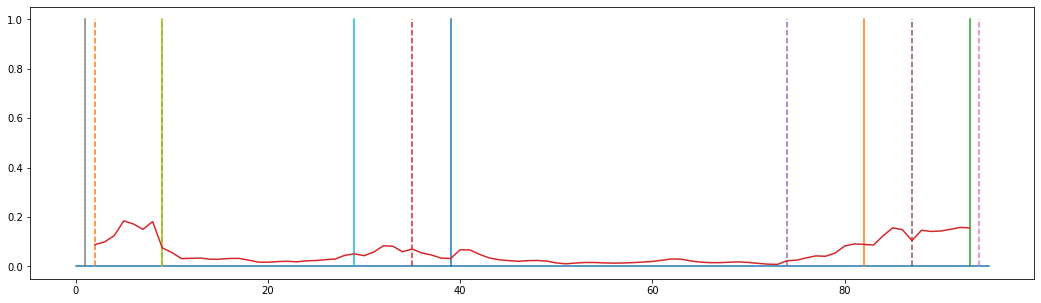

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 1], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 1])
    
all_prob = []
for segment in prob_each_segment:
    all_prob.append(segment/torch.sum(segment))

all_prob = torch.cat(all_prob).cpu().numpy()
xs = np.arange(loaded_vidid_selected_frames[cur_vidid][0], loaded_vidid_selected_frames[cur_vidid][-1])
plt.plot(xs, all_prob, '-')

In [60]:
from sklearn.cluster import KMeans

In [109]:
model.eval()
gt_seg = 0
pred_seg = 0
err = []

for i, item in enumerate(trainloader):
    print(f'Batch {i} started')
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        features, _  = model(item[0].permute(0,2,1), [1,1,1,1,1,1])
        features = features.permute(0,2,1)
        
        for j in range(len(features)):
            vid_count = item[1][j].item()
            vid_labels = item[2][j][:vid_count]
            vid_feat = features[j][:vid_count]
            segments = vid_labels[:-1][vid_labels[1:]!=vid_labels[:-1]]
            segments = torch.cat([segments, vid_labels[-1].unsqueeze(dim=0)])
            np_features = vid_feat.cpu().numpy()
            
            num_seg = len(segments)
            
            clust = KMeans(n_clusters=num_seg).fit(np_features)
            cluster_labels = clust.labels_
            cluster_centers = clust.cluster_centers_

            nearest_points = [np.argmin(np.linalg.norm(np_features[cluster_labels==k] - cluster_centers[k][None,:], 
                                                       axis=-1)) for k in range(num_seg)]
            actual_pos = [np.arange(vid_count)[cluster_labels==k][pt] for k,pt in enumerate(nearest_points)]

            predicted_segment_arr = vid_labels[np.sort(actual_pos)]
            num_predicted_segments = torch.sum(predicted_segment_arr[1:]!=predicted_segment_arr[:-1]) + 1
            
            gt_seg += num_seg
            pred_seg += num_predicted_segments
            err.append(num_seg - num_predicted_segments)

#         get_estimated_boundary(features, item[1], item[5])
# get_boundary_err()

Batch 0 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 1 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 2 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 3 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 4 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 5 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 6 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 7 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 8 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 9 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 10 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 11 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 12 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 13 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 14 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 15 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 16 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 17 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 18 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 19 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 20 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 21 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 22 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 23 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 24 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Batch 25 done


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Avergage error = 48.193


((array([378., 413., 196., 196.,  37.,  18.,  15.,   2.,   2.,   4.]),
  array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
  <a list of 10 Patch objects>),
 tensor(37.2266))

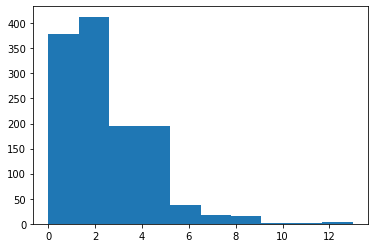

In [111]:
plt.hist(err), 100*(gt_seg - pred_seg)/gt_seg

In [100]:
j=2
vid_count = item[1][j].item()
vid_labels = item[2][j][:vid_count]
vid_feat = features[j][:vid_count]
segments = vid_labels[:-1][vid_labels[1:]!=vid_labels[:-1]]
segments = torch.cat([segments, vid_labels[-1].unsqueeze(dim=0)])
np_features = vid_feat.cpu().numpy()

# clust = KMeans(n_clusters=len(segments)).fit(np_features)
# cluster_labels = clust.labels_
# cluster_centers = clust.cluster_centers_

nearest_points = [np.argmin(np.linalg.norm(np_features[cluster_labels==k] - cluster_centers[k][None,:], axis=-1)) 
                  for k in range(len(segments))]
actual_pos = [np.arange(vid_count)[cluster_labels==k][pt] for k,pt in enumerate(nearest_points)]

predicted_segment_arr = vid_labels[np.sort(actual_pos)]
num_predicted_segments = torch.sum(predicted_segment_arr[1:]!=predicted_segment_arr[:-1]) + 1